In [1]:
import matplotlib.pyplot as plt
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

device: cpu


In [39]:
# Define my colors
MY_BLUE = '#2774AE'
MY_GOLD = '#FFD100'

Generating Gaussian (Normal) Data Points

Covariates: $X$ ~ $N(0,I_d)$ \\
Response: $y = \langle x, \beta \rangle + N(0,\sigma^2)$

In [3]:
d = 200 # fix the dimension (number of weights) of the linear model
beta  = torch.rand(d) # set the actual weights
beta  = beta / torch.norm(beta) # norm of beta = 1
sigma = 0.5 # std for noise
sim   = 40  # conducting 20 simulations for each value of n

smallest_n = torch.arange(1, 5, 1)
smaller_n  = torch.arange(5, 170, 5)
small_n    = torch.arange(170, 196, 2)
around     = torch.arange(196, 204, 1)
large_n    = torch.arange(204, 250, 2)
larger_n   = torch.arange(250, 600, 5)
n_vals = torch.cat([smallest_n, smaller_n, small_n, around, large_n, larger_n])
M = n_vals.size()[0]
print(f'We set {M} candidates for sample size (n).')

We set 151 candidates for sample size (n).


In [48]:
def run_simulation(n_vals, num_sim, s, d):
    M = n_vals.size()[0]
    train_mse = torch.zeros((M, num_sim))
    test_mse  = torch.zeros((M, num_sim))
    L2_train_mse = torch.zeros((M, num_sim))
    L2_test_mse  = torch.zeros((M, num_sim))

    for i in range(M):
        for j in range(num_sim):
            n = n_vals[i] # sample size
            mean = torch.zeros((d,))
            Id = torch.eye(d)
            norm = MultivariateNormal(mean, Id)
            X_train = norm.sample(sample_shape=(n,)) # X training data
            X_test  = norm.sample(sample_shape=(n,)) # X testing data
            noise1 = torch.normal(torch.zeros((n,)), torch.full((n,), s))
            noise2 = torch.normal(torch.zeros((n,)), torch.full((n,), s))
            Y_train = torch.matmul(X_train, beta) + noise1
            Y_test  = torch.matmul(X_test, beta) + noise2

            # vanilla linear regression
            if n < d:
                beta_hat = torch.matmul(torch.linalg.pinv(X_train), Y_train)
            else:
                p1 = torch.linalg.inv(torch.matmul(torch.t(X_train), X_train))
                p2 = torch.matmul(p1, torch.t(X_train))
                beta_hat = torch.matmul(p2, Y_train)

            train_pred = torch.matmul(X_train, beta_hat)
            test_pred  = torch.matmul(X_test,  beta_hat)
            train_mse[i,j] = torch.mean((Y_train - train_pred)**2)
            test_mse[i,j]  = torch.mean((Y_test - test_pred)**2)

            # linear regression with L2 regularization
            q1 = torch.linalg.inv(torch.matmul(torch.t(X_train), X_train) + n*Id)
            q2 = torch.matmul(q1, torch.t(X_train))
            L2_beta_hat = torch.matmul(q2, Y_train)

            train_pred = torch.matmul(X_train, L2_beta_hat)
            test_pred  = torch.matmul(X_test,  L2_beta_hat)
            L2_train_mse[i,j] = torch.mean((Y_train - train_pred)**2)
            L2_test_mse[i,j]  = torch.mean((Y_test - test_pred)**2)

    return train_mse, test_mse, L2_train_mse, L2_test_mse

Next, we plot the results:

In [49]:
# NOTE: it takes about 2min to run this cell on Macbook Pro 2019 intel cpu.

train_mse, test_mse, bias, variance=run_simulation(n_vals,sim,sigma,d)
avgs_train_loss    = torch.mean(train_mse, 1)
avgs_test_loss     = torch.mean(test_mse, 1)
L2_avgs_train_loss = torch.mean(bias, 1)
L2_avgs_test_loss  = torch.mean(variance, 1)

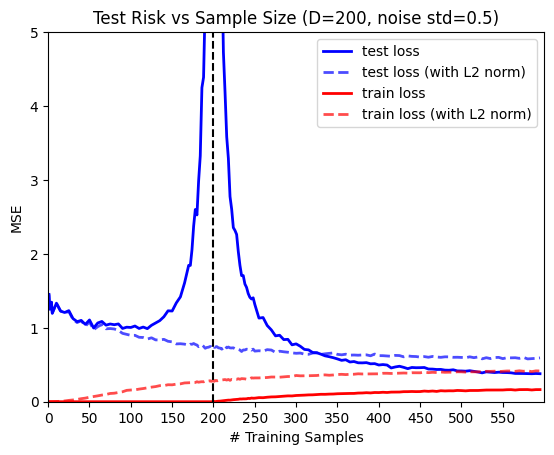

In [50]:
plt.title("Test Risk vs Sample Size (D=200, noise std=0.5)")
plt.xlabel("# Training Samples")
plt.ylabel("MSE")
plt.ylim(0, 5)
plt.xlim(0, 600)
plt.plot(n_vals.cpu().numpy(), avgs_test_loss.cpu().numpy(), lw=2, c='blue',
         label='test loss')
plt.plot(n_vals.cpu().numpy(), L2_avgs_test_loss.cpu().numpy(), lw=2, c='blue',
         label='test loss (with L2 norm)', alpha=0.7, ls='--')
plt.plot(n_vals.cpu().numpy(), avgs_train_loss.cpu().numpy(), lw=2, c='red',
         label='train loss')
plt.plot(n_vals.cpu().numpy(), L2_avgs_train_loss.cpu().numpy(), lw=2, c='red',
         label='train loss (with L2 norm)', alpha=0.7, ls='--')
plt.axvline(x=d, color='black', ls='--')
plt.xticks(torch.arange(0,600,step=50).cpu().numpy())
plt.legend(loc="best")
plt.show()

In [36]:
def run_theory(n_vals, s, d):
    M = n_vals.size()[0]
    bias      = torch.zeros((M,))
    variance  = torch.zeros((M,))

    for i in range(M):
        n = n_vals[i] # sample size
        gamma = n / d
        beta_L2 = (torch.norm(beta, 2))**2
        if gamma > 1:
            bias[i] = 0
            variance[i] = s**2 / (gamma - 1)
        else:
            bias[i] = (1-gamma)**2 * beta_L2
            variance[i] = gamma*(1-gamma) * beta_L2 + s**2 * n / (d - n)

    return bias, variance

In [37]:
bias, variance = run_theory(n_vals, sigma, d)

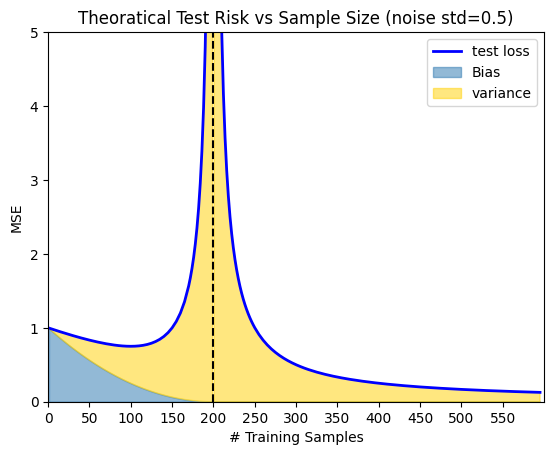

In [44]:
plt.title("Theoratical Test Risk vs Sample Size (noise std=0.5)")
plt.xlabel("# Training Samples")
plt.ylabel("MSE")
plt.ylim(0, 5)
plt.xlim(0, 600)
plt.plot(n_vals, variance+bias, lw=2, c='blue', label='test loss')
plt.fill_between(x=n_vals, y1=bias, color=MY_BLUE, alpha=0.5, label='Bias')
plt.fill_between(x=n_vals, y1=bias, y2=variance+bias, color=MY_GOLD, alpha=0.5,
                 label='variance')
plt.axvline(x=d, color='black', ls='--')
plt.xticks(torch.arange(0,600,step=50))
plt.legend(loc="best")
plt.show()

In [28]:
n_vals[0] / 200 > 1

tensor(False)